# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Structured Streaming (Window-based aggregations)** </center>
---
**Profesor**: Pablo Camarillo Ramirez

# Create SparkSession

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (Kafka)") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7b1c69b3-ba21-4eb4-afa0-5e54e8b1a378;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

# Create a data stream from a Kafka topic

In [2]:
# Create the remote connection
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", "kafka-spark-example") \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [3]:
from pyspark.sql.functions import explode, split, window
input_df = kafka_df.withColumn("value_str",
                               kafka_df.value.cast("string"))

input_df = input_df.select("value_str", "timestamp")

words = input_df.select(explode(split(input_df.value_str, " ")).alias("word"), "timestamp")

In [4]:
# The watermark allows late data to update the state within 2 minutes.
# Late data beyond the 2-minute threshold will be dropped.

windowd_counts = words \
                .withWatermark("timestamp", "2 minutes") \
                .groupBy(window(words.timestamp,
                                "30 seconds",
                                "15 seconds"),
                                words.word) \
                .count()

query_count = windowd_counts.writeStream \
        .trigger(processingTime='2 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()

query_count.awaitTermination(300)

25/10/17 12:53:20 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-91b9e64d-3395-4336-a45e-9d2c20828c53. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/17 12:53:20 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/10/17 12:53:23 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 2000} milliseconds, but spent 2935 milliseconds


-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|word|count|
+------+----+-----+
+------+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+----+-----+
|window                                    |word|count|
+------------------------------------------+----+-----+
|{2025-10-17 12:53:15, 2025-10-17 12:53:45}|hola|1    |
|{2025-10-17 12:53:00, 2025-10-17 12:53:30}|hola|1    |
+------------------------------------------+----+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |word  |count|
+------------------------------------------+------+-----+
|{2025-10-17 12:53:15, 2025-10-17 12:53:45}|es    |1    |
|{2025-10-17 12:53:30, 2025-10-17 12:54:00}|una   |1    |
|{2025-10-17 12:53:30, 2025-10-17 12:54:00}|es    |1    |
|{2025-10-17 12:53:15, 2025-10-17 12:53:45}|esto  |1    |
|{2025-10-17 12:53:15, 2025-10-17 12:53:45}|hola  |1    |
|{202

False

In [5]:
query_count.stop()

25/10/17 12:58:20 WARN DAGScheduler: Failed to cancel job group e383b2b1-4c21-448e-901e-aa2cbee74e2a. Cannot find active jobs for it.
25/10/17 12:58:20 WARN DAGScheduler: Failed to cancel job group e383b2b1-4c21-448e-901e-aa2cbee74e2a. Cannot find active jobs for it.


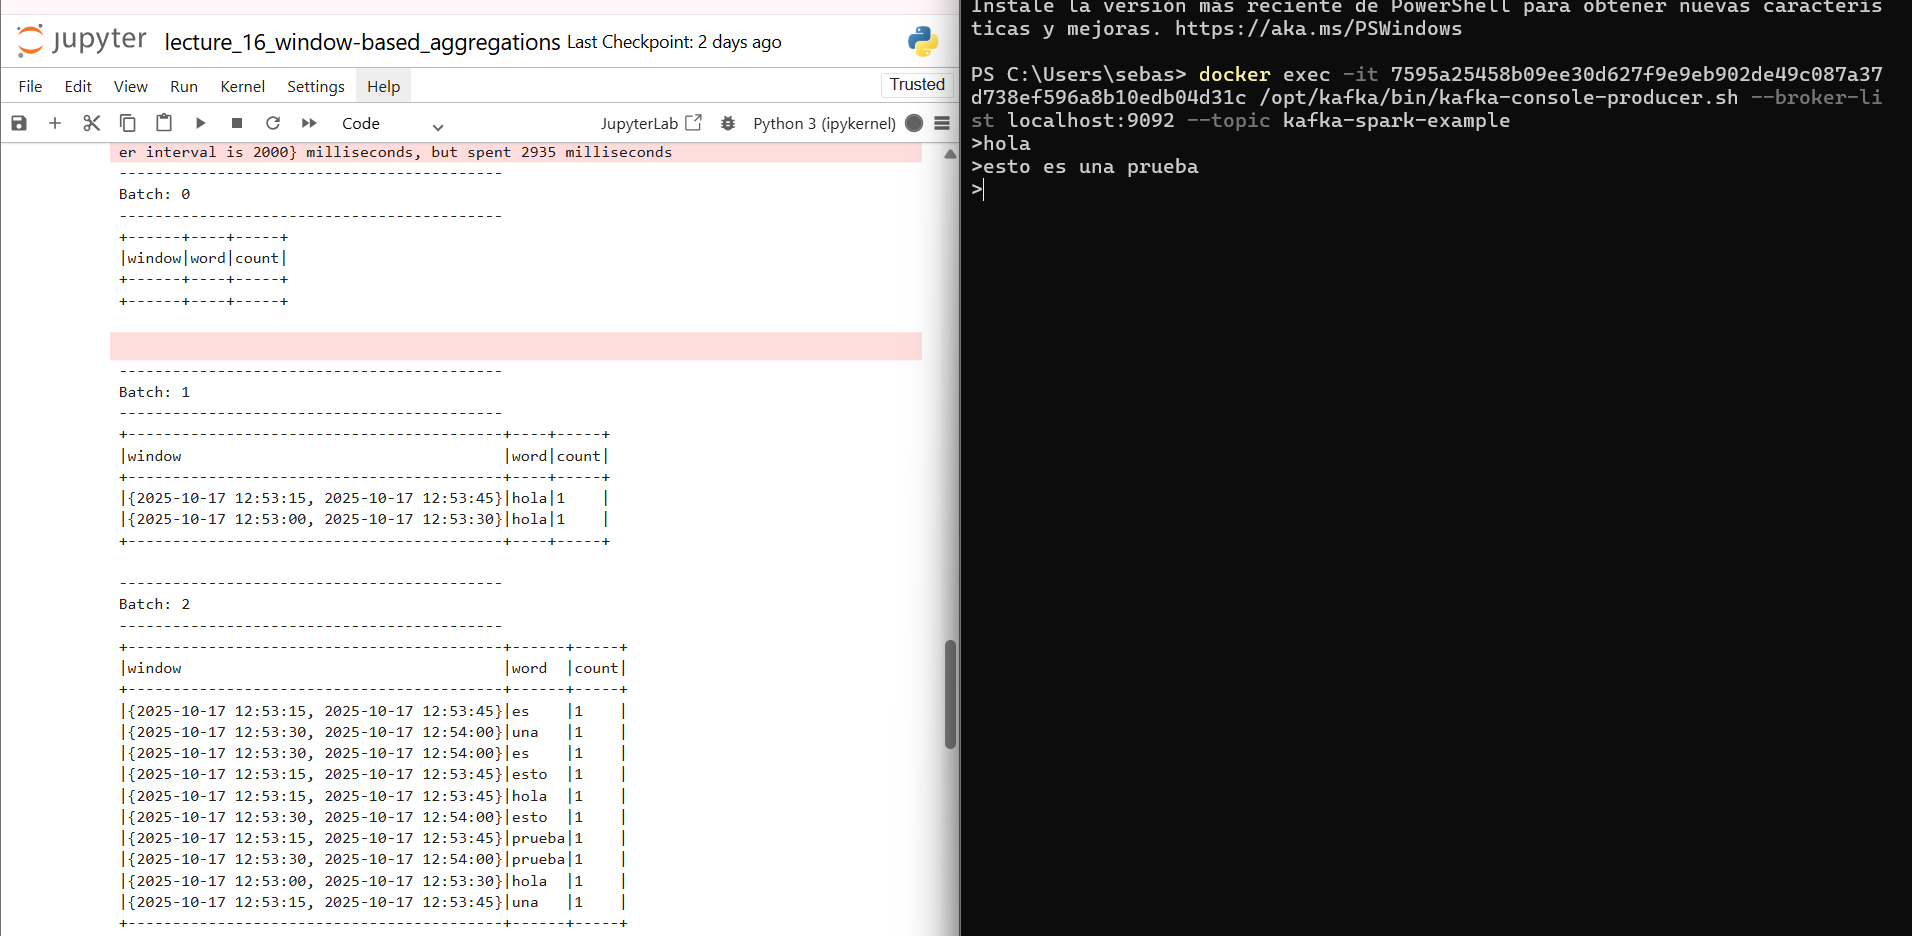

In [6]:
# Create a new streaming query with another aggregation operation(avg, sum, min, or max)
from pyspark.sql.functions import count, max
windowd_max = words.groupBy("word") \
                .agg(
                    count("*").alias("count"),
                    max("timestamp").alias("latest_timestamp")
                )

query_max = windowd_max.writeStream \
        .trigger(processingTime='4 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()

25/10/17 12:58:56 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-20511104-0e37-4fa1-924d-4b4dad60d9d8. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/17 12:58:56 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+----------------+
|word|count|latest_timestamp|
+----+-----+----------------+
+----+-----+----------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+----+-----+-----------------------+
|word|count|latest_timestamp       |
+----+-----+-----------------------+
|hola|1    |2025-10-17 13:00:13.932|
+----+-----+-----------------------+

-------------------------------------------
Batch: 2
-------------------------------------------
+------+-----+-----------------------+
|word  |count|latest_timestamp       |
+------+-----+-----------------------+
|MAX   |1    |2025-10-17 13:00:31.745|
|esto  |1    |2025-10-17 13:00:31.745|
|es    |1    |2025-10-17 13:00:31.745|
|del   |1    |2025-10-17 13:00:31.745|
|una   |1    |2025-10-17 13:00:31.745|
|prueba|1    |2025-10-17 13:00:31.745|
|hola  |1    |2025-10-17 13:00:13.932|
+------+----

In [7]:
query_max.stop()

25/10/17 13:00:43 WARN DAGScheduler: Failed to cancel job group ff69fead-f5af-4156-825e-f33143700cab. Cannot find active jobs for it.
25/10/17 13:00:43 WARN DAGScheduler: Failed to cancel job group ff69fead-f5af-4156-825e-f33143700cab. Cannot find active jobs for it.


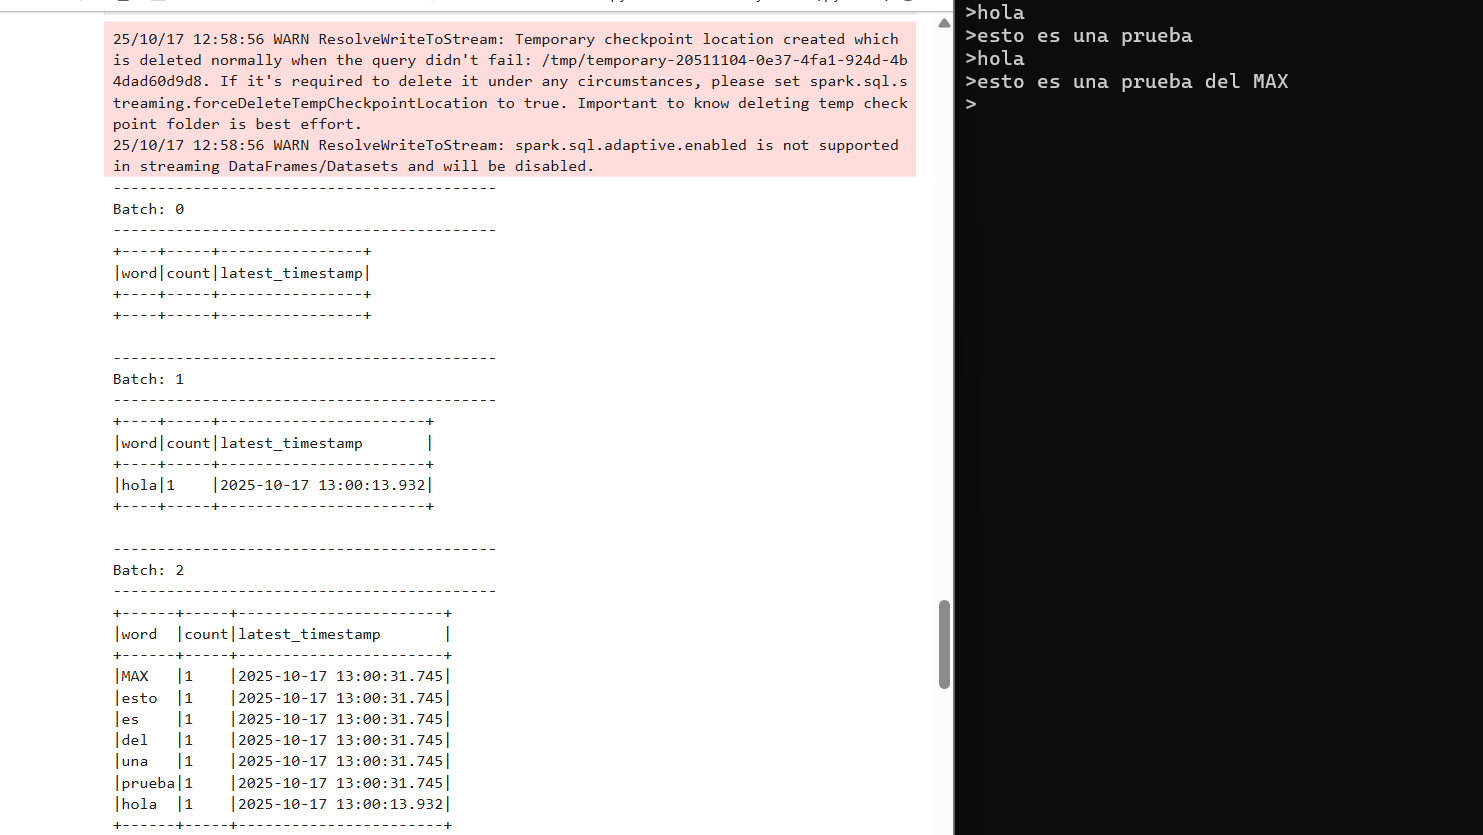

In [8]:
from pyspark.sql.functions import min
windowd_min = words.groupBy("word") \
                .agg(
                    count("*").alias("count"),
                    min("timestamp").alias("earliest_timestamp")
                )

query_min = windowd_min.writeStream \
        .trigger(processingTime='4 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()

25/10/17 13:01:05 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-d8045bdb-f1a0-4fe0-9562-f985965fb198. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/17 13:01:05 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+------------------+
|word|count|earliest_timestamp|
+----+-----+------------------+
+----+-----+------------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+----+-----+-----------------------+
|word|count|earliest_timestamp     |
+----+-----+-----------------------+
|otra|1    |2025-10-17 13:01:11.782|
|vez |1    |2025-10-17 13:01:11.782|
|hola|1    |2025-10-17 13:01:11.782|
+----+-----+-----------------------+

-------------------------------------------
Batch: 2
-------------------------------------------
+------+-----+-----------------------+
|word  |count|earliest_timestamp     |
+------+-----+-----------------------+
|ahora |1    |2025-10-17 13:01:19.709|
|otra  |2    |2025-10-17 13:01:11.782|
|vez   |1    |2025-10-17 13:01:11.782|
|MIN   |1    |2025-10-17 13:01:19.709|
|es    |1    |2025-10-17 13:01:19.709|
|del   |

In [9]:
query_min.stop()

25/10/17 13:05:32 WARN DAGScheduler: Failed to cancel job group ea82ebd3-cb58-44e9-92dd-2027dfaadf8f. Cannot find active jobs for it.
25/10/17 13:05:32 WARN DAGScheduler: Failed to cancel job group ea82ebd3-cb58-44e9-92dd-2027dfaadf8f. Cannot find active jobs for it.


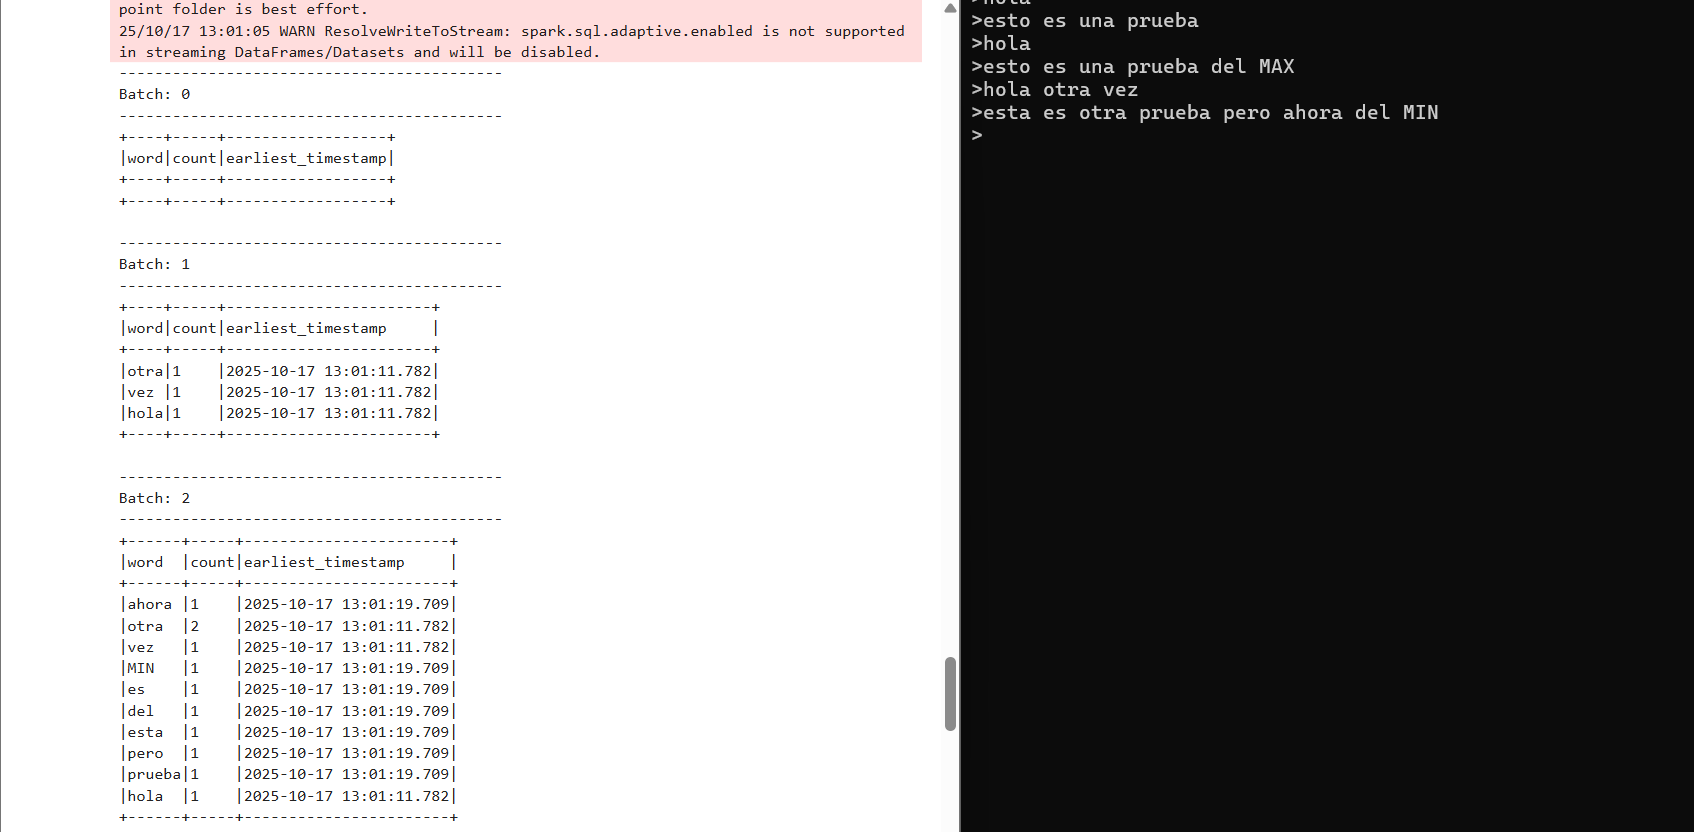

In [11]:
from pyspark.sql.functions import sum, col

words_with_value = words.withColumn("value", col("word").isNotNull().cast("int"))

windowd_sum = words_with_value.groupBy("word") \
                .agg(
                    count("*").alias("count"),
                    sum("value").alias("total_value")
                )

query_sum = windowd_sum.writeStream \
        .trigger(processingTime='4 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()


25/10/17 13:15:40 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-b11f6d67-95fc-47e2-9fed-fd016a5da1db. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/17 13:15:40 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+-----------+
|word|count|total_value|
+----+-----+-----------+
+----+-----+-----------+



-------------------------------------------
Batch: 1
-------------------------------------------
+----+-----+-----------+
|word|count|total_value|
+----+-----+-----------+
|esto|1    |1          |
|para|1    |1          |
|es  |1    |1          |
|sum |1    |1          |
+----+-----+-----------+



-------------------------------------------
Batch: 2
-------------------------------------------
+--------+-----+-----------+
|word    |count|total_value|
+--------+-----+-----------+
|parece  |1    |1          |
|esto    |1    |1          |
|para    |1    |1          |
|es      |1    |1          |
|funciona|1    |1          |
|si      |1    |1          |
|sum     |2    |2          |
|que     |1    |1          |
+--------+-----+-----------+



-------------------------------------------
Batch: 3
-------------------------------------------
+--------+-----+-----------+
|word    |count|total_value|
+--------+-----+-----------+
|parece  |1    |1          |
|esto    |1    |1          |
|bueno   |1    |1          |
|para    |1    |1          |
|es      |1    |1          |
|funciona|2    |2          |
|sum     |3    |3          |
|que     |3    |3          |
|si      |1    |1          |
+--------+-----+-----------+



In [12]:
query_sum.stop()

25/10/17 13:16:44 WARN DAGScheduler: Failed to cancel job group 21fd0b58-d05f-4936-917a-6920b9e748ac. Cannot find active jobs for it.
25/10/17 13:16:44 WARN DAGScheduler: Failed to cancel job group 21fd0b58-d05f-4936-917a-6920b9e748ac. Cannot find active jobs for it.


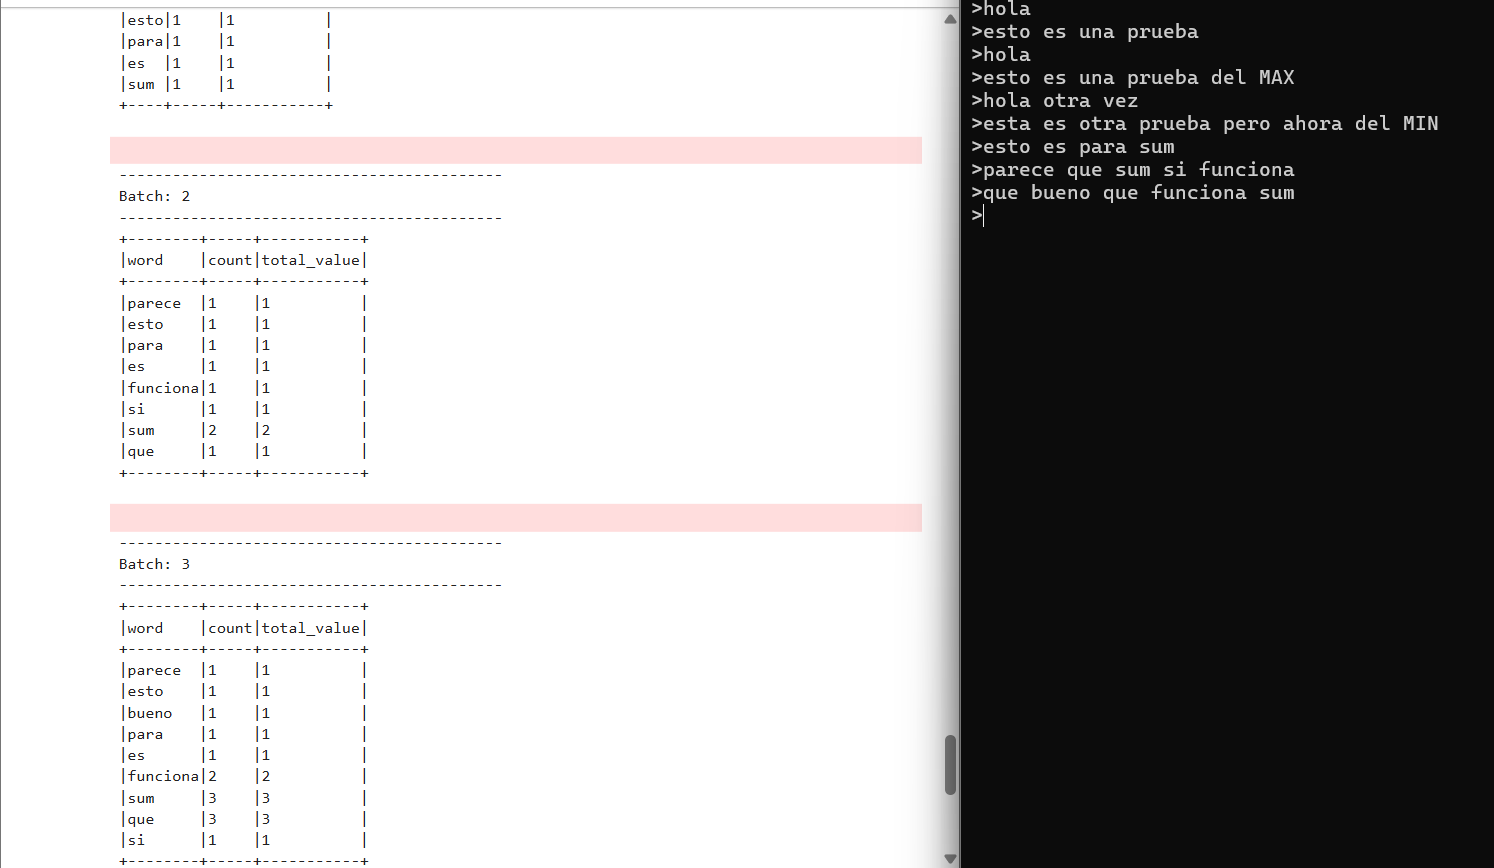

In [13]:
from pyspark.sql.functions import avg

words_with_value = words.withColumn("value", col("word").isNotNull().cast("int"))

windowd_avg = words_with_value.groupBy("word") \
                .agg(
                    count("*").alias("count"),
                    avg("value").alias("average_value")
                )

query_avg = windowd_avg.writeStream \
        .trigger(processingTime='4 seconds') \
        .outputMode("complete") \
        .format("console") \
        .option("truncate", "false") \
        .start()


25/10/17 13:18:29 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-b40f51ab-e07e-49de-816b-58f64f1b9717. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/10/17 13:18:29 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+-------------+
|word|count|average_value|
+----+-----+-------------+
+----+-----+-------------+



-------------------------------------------
Batch: 1
-------------------------------------------
+------+-----+-------------+
|word  |count|average_value|
+------+-----+-------------+
|patra |1    |1.0          |
|la    |1    |1.0          |
|avg   |1    |1.0          |
|es    |1    |1.0          |
|esta  |1    |1.0          |
|prueba|1    |1.0          |
+------+-----+-------------+

-------------------------------------------
Batch: 2
-------------------------------------------
+------+-----+-------------+
|word  |count|average_value|
+------+-----+-------------+
|patra |1    |1.0          |
|la    |1    |1.0          |
|es    |1    |1.0          |
|avg   |2    |1.0          |
|nueva |1    |1.0          |
|de    |1    |1.0          |
|esta  |1    |1.0          |
|prueba|2    |1.0          |
+------+-----+-------------+



-------------------------------------------
Batch: 3
-------------------------------------------
+------+-----+-------------+
|word  |count|average_value|
+------+-----+-------------+
|patra |1    |1.0          |
|la    |1    |1.0          |
|de    |1    |1.0          |
|es    |1    |1.0          |
|avg   |3    |1.0          |
|nueva |1    |1.0          |
|esta  |1    |1.0          |
|prueba|2    |1.0          |
+------+-----+-------------+



In [14]:
query_avg.stop()

25/10/17 13:20:42 WARN DAGScheduler: Failed to cancel job group b0e99ac1-8d5c-4c1a-8fe3-c7553221db7c. Cannot find active jobs for it.
25/10/17 13:20:42 WARN DAGScheduler: Failed to cancel job group b0e99ac1-8d5c-4c1a-8fe3-c7553221db7c. Cannot find active jobs for it.


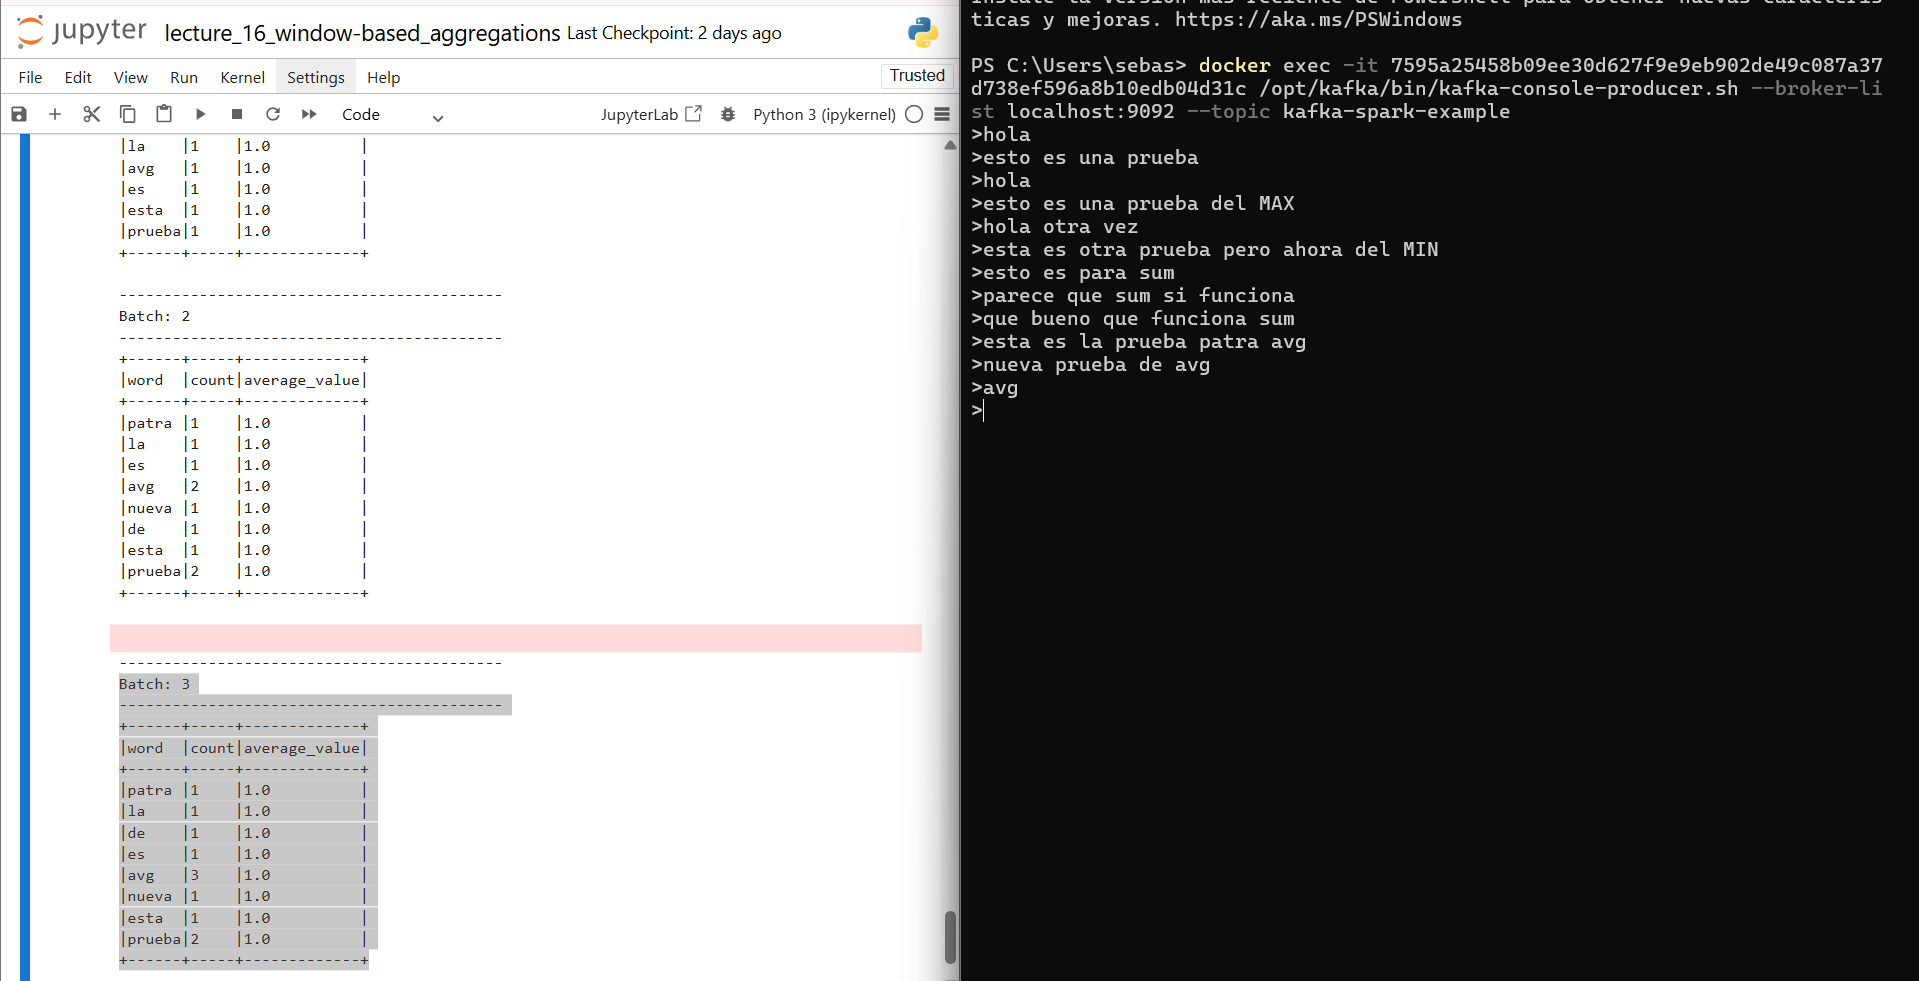

In [ ]:
sc.stop()